In [2]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.mmmtools import *
from forse.tools.nn_tools import *

In [3]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/', img_size=(64, 64))

In [4]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
accs = np.load(dir_models+'acc_dreal_dfake_99999.npy')
dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
patch_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
Ys, Xs = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix64_set2.npy')
Yl, Xl = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR1deg_LR5deg_Npix320_set2.npy')
Yl_zoom = np.zeros((1000, 64, 64))
X_edges = []
for i in range(40):
    Yl_zoom[i*25:(i+1)*25] = divide_image(Yl[i])
X = Yl_zoom
for i in range(X.shape[0]):
    X[i], Xmin, Xmax = rescale_min_max(X[i], return_min_max=True)
    X_edges.append([Xmin, Xmax])
x_test, x_test2 = split_training_set(X)
X_edges = np.array(X_edges)    

In [6]:
gen_imgs_test = dcgan.generator.predict(x_test)

In [7]:
pysm_ss, pysm_1d = np.load(patch_path+'training_set_PySM_1000patches_20x20def_T_HR12amin_LR1deg_Npix320_set2.npy')
pysm_ss_zoom = np.zeros((1000, 64, 64))
pysm_1d_zoom = np.zeros((1000, 64, 64))
pysm_ss_edges = []
for i in range(40):
    pysm_ss_zoom[i*25:(i+1)*25] = divide_image(pysm_ss[i])
    pysm_1d_zoom[i*25:(i+1)*25] = divide_image(pysm_1d[i])
for i in range(1000):
    ratio = pysm_ss_zoom/pysm_1d_zoom
    pysm_ss_edges.append([ratio[i].min(), ratio[i].max()])
pysm_ss_edges = np.array(pysm_ss_edges)

In [8]:
def normalize_back(image, edges):
    nimage = (image+1)/2.*(edges[1]-edges[0])+edges[0]
    return(nimage)

In [9]:
normed_gen_mean = np.copy(gen_imgs_test)
normed_gen = np.copy(gen_imgs_test)
for i in range(800):
    normed_gen_mean[i] = (normalize_back(gen_imgs_test[i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))
    normed_gen[i] = (normalize_back(gen_imgs_test[i], pysm_ss_edges[i]))

In [10]:
a = 475
b = a+25
small_scale = unify_image(normed_gen_mean[a:b])
input_imgs = unify_image(x_test[a:b])
large_scale = pysm_1d[int(a/25)]

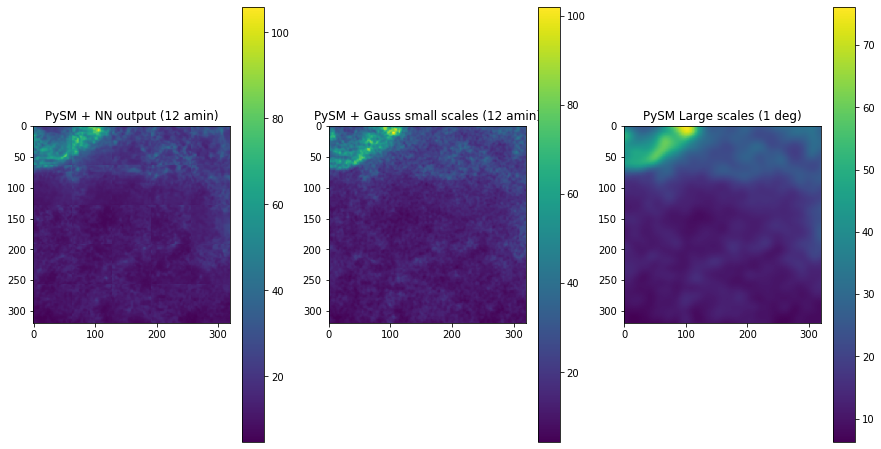

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow((small_scale*large_scale))
plt.colorbar()
plt.title('PySM + NN output (12 amin)')
plt.subplot(132)
plt.imshow((pysm_ss[int(a/25)]))
plt.colorbar()
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow(large_scale)
plt.title('PySM Large scales (1 deg)')
plt.colorbar()



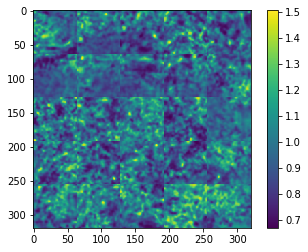

In [12]:
plt.imshow(small_scale)
plt.colorbar()

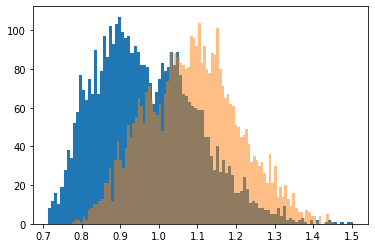

In [13]:
hist = plt.hist(normed_gen_mean[492].flatten(), bins=100)
hist = plt.hist(normed_gen_mean[100].flatten(), bins=100, alpha=0.5)

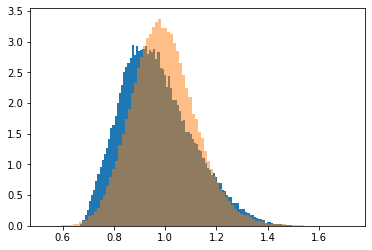

In [14]:
hist = plt.hist((small_scale).flatten(), bins=100, density=1)
hist = plt.hist((pysm_ss[int(a/25)]/large_scale).flatten(), bins=100, alpha=0.5, density=1)

# SMOOTHING

In [15]:
def low_pass_filter(npix_tot, npix1, npix2=None):
    if not npix2:
        npix2 = npix_tot
    pix = np.arange(npix_tot)
    filt = 0.5*(1-np.cos(np.pi*(npix2-pix)/(npix2-npix1)))
    filt[0:npix1] = 1.
    return np.array([filt])
def high_pass_filter(npix_tot, npix2, npix1=None):
    if not npix1:
        npix1 = 0
    pix = np.arange(npix_tot)
    filt = 0.5*(1-np.cos(np.pi*(pix-npix1)/(npix2-npix1)))
    filt[npix2:npix_tot] = 1.
    return np.array([filt])

In [16]:
def forward(image, step, side) :
    """
    Parameters
    ----------
    image : array-like object shape = ( npix, npix )
    step : lenght to move in decomposition
    side : side lenght of output images

    Returns
    -------
    image array, pixel weight, limiting indexes of images in array
    """

    # preliminaries and exceptions
    xnpix, ynpix = image.shape
    if (xnpix==ynpix):
        imgside = xnpix
    else:
        raise ValueError("Function forward only works for square images.")
    if (step<=side):
        pass
    else:
        raise ValueError("'side' should be greater than or equal to 'step'.")
    if (side<=imgside ):
        pass
    else:
        raise ValueError("'side' should be strictly smaller than the original image side lenght.")
    if imgside%step==0:
        pass
    else:
        raise ValueError("Step lenght selected not valid ('imside' should be a multipole of 'step')")

    # create array of ranges for slicing
    img_index = np.array([[idx, min(idx+side, ynpix)]
                        for idx in range(0, imgside, step)])
    sider = np.array([np.arange(idx[0], idx[1]) for idx in img_index])

    # create output array of images
    NN = int(imgside/step)-1
    img_array = np.zeros(shape=(NN*NN, side, side))
    img_weights = np.zeros(shape=image.shape)
    for ii in range(0, NN):
        for jj in range(0, NN):
            img_array[ii * NN + jj,
                       :img_index[ii, 1] - img_index[ii, 0],
                       :img_index[jj, 1] - img_index[jj, 0]] += image[np.ix_(sider[ii], sider[jj])]
            img_weights[np.ix_(sider[ii], sider[jj])] += 1

    return img_array, img_weights, img_index

In [17]:
images_oversamp = forward(large_scale, 32, 64)
Xos = np.array(images_oversamp[0])
indx = images_oversamp[2]
weights = images_oversamp[1]

In [18]:
for i in range(Xos.shape[0]):
    Xos[i] = 2*(Xos[i]-Xos[i].min())/(Xos[i].max()-Xos[i].min())-1
Xos = Xos.reshape(Xos.shape[0], 64, 64, 1)
gen_imgs_os = dcgan.generator.predict(Xos)

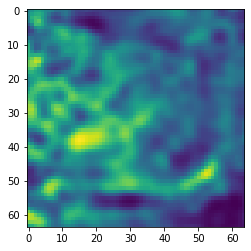

In [19]:
plt.imshow(gen_imgs_os[0, :, :, 0])

In [20]:
nn_images_oversamp = np.copy(images_oversamp)
nn_images_oversamp[0] = gen_imgs_os[:, :, :, 0]
for i in range(len(nn_images_oversamp[0])):
    nn_images_oversamp[0][i] = (normalize_back(nn_images_oversamp[0][i], [np.mean(pysm_ss_edges[:,0]), np.mean(pysm_ss_edges[:,1])]))

In [21]:
def filter_images(images_oversamp, step=32):
    image_array = images_oversamp[0]
    weights = images_oversamp[1]
    index = images_oversamp[2]
    lpf = low_pass_filter(64, 64-step)
    hpf = high_pass_filter(64, step)
    Nimg = image_array.shape[0]
    nlc = int(np.sqrt(Nimg))
    temp_image = np.zeros(weights.shape[0]*nlc, weights.shape[1])
    for nl in range(nlc):
        if nl==0:
            image_array[nl*nlc:(nl*nlc)+nlc] = image_array[nl*nlc:(nl*nlc)+nlc]*lpf.T
        elif nl==nline-1:
            image_array[nl*nlc:(nl*nlc)+nlc] = image_array[nl*nlc:(nl*nlc)+nlc]*hpf.T
        else:
            image_array[nl*nlc:(nl*nlc)+nlc] = image_array[nl*nlc:(nl*nlc)+nlc]*hpf.T*lpf.T
    
    return image_array

In [22]:
def filter_images_2(images_oversamp, step=32):
    image_array = images_oversamp[0]
    weights = images_oversamp[1]
    indx = images_oversamp[2]
    lpf = low_pass_filter(64, 64-step)
    hpf = high_pass_filter(64, step)
    Nimg = image_array.shape[0]
    nlc = int(np.sqrt(Nimg))
    temp_image = np.zeros((weights.shape[0], 64*nlc))
    for nl in range(nlc):
        for i in range(nlc):
            if nl==0:
                temp_image[indx[nl, 0]:indx[nl, 1], 64*i:(64*i)+64] += image_array[nl*nlc+i]*lpf.T
            elif nl==nlc-1:
                temp_image[indx[nl, 0]:indx[nl, 1], 64*i:(64*i)+64] += image_array[nl*nlc+i]*hpf.T
            else:
                temp_image[indx[nl, 0]:indx[nl, 1], 64*i:(64*i)+64] += image_array[nl*nlc+i]*hpf.T*lpf.T
    out_image = np.zeros((weights.shape[0], weights.shape[1]))
    for nl in range(nlc):
            if nl==0:
                out_image[:, indx[nl, 0]:indx[nl, 1]] += temp_image[:,64*nl:(64*nl)+64]*lpf
            elif nl==nlc-1:
                out_image[:, indx[nl, 0]:indx[nl, 1]] += temp_image[:,64*nl:(64*nl)+64]*hpf
            else:
                out_image[:, indx[nl, 0]:indx[nl, 1]] += temp_image[:,64*nl:(64*nl)+64]*hpf*lpf               
    return out_image

In [23]:
pippo = filter_images_2(nn_images_oversamp)

In [24]:
pippo.shape

(320, 320)

Text(0.5, 1.0, 'PySM Large scales (1 deg)')

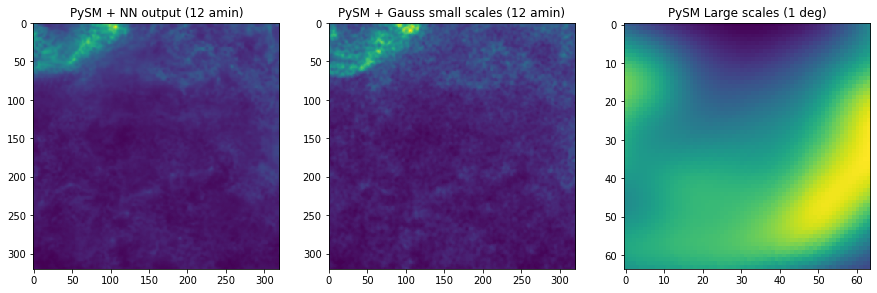

In [25]:
plt.figure(figsize=(15, 8))
#plt.subplot(131)
#plt.imshow((small_scale*large_scale))
#plt.colorbar()
#plt.title('PySM + NN output (12 amin)')
plt.subplot(131)
plt.imshow((pippo*large_scale))
#plt.colorbar()
plt.title('PySM + NN output (12 amin)')
plt.subplot(132)
plt.imshow(((pysm_ss[int(a/25)])))
#plt.colorbar()
plt.title('PySM + Gauss small scales (12 amin)')
plt.subplot(133)
plt.imshow((large_scale[0:64, 0:64]))
plt.title('PySM Large scales (1 deg)')
#plt.colorbar()



Text(0.5, 1.0, 'PySM + Gauss small scales (12 amin)')

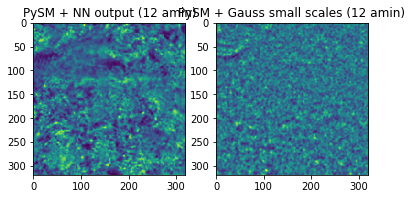

In [26]:
sp = 4
plt.subplot(121)
plt.imshow((pippo))
#plt.colorbar()
plt.title('PySM + NN output (12 amin)')
plt.subplot(122)
plt.imshow((pysm_ss[int(a/25)])/large_scale)
#plt.colorbar()
plt.title('PySM + Gauss small scales (12 amin)')

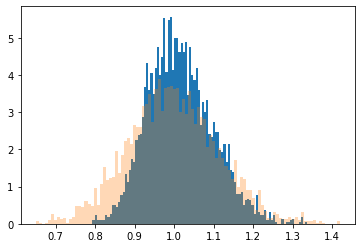

In [27]:
hist = plt.hist((pippo[2*64:3*64, 2*64:3*64]).flatten(), bins=100, density=1)
hist = plt.hist((pysm_ss[int(a/25)][2*64:3*64, 2*64:3*64]/large_scale[2*64:3*64, 2*64:3*64]).flatten(), bins=100, alpha=0.3, density=1)

In [28]:
def calculate_2d_spectrum(Map1,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    #FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap1))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

In [29]:
binned_ell, binned_spectrumLS = calculate_2d_spectrum(pysm_1d[int(a/25)],20,1024,3.75,320)
binned_ell, binned_spectrumSS = calculate_2d_spectrum(pysm_ss[int(a/25)],20,1024,3.75,320)
binned_ell, binned_spectrumNN = calculate_2d_spectrum(small_scale*large_scale,20,1024,3.75,320)
binned_ell, pippo_spec = calculate_2d_spectrum(pippo*large_scale,20,1024,3.75,320)

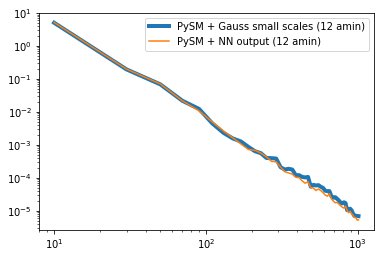

In [30]:
#plt.loglog(binned_ell, binned_spectrumSS)
plt.loglog(binned_ell, binned_spectrumNN, label='PySM + Gauss small scales (12 amin)', lw=4)
plt.loglog(binned_ell, pippo_spec, label='PySM + NN output (12 amin)', alpha=1)
plt.legend()
